# Test Setup for Transient Analysis

In [2]:
from CircuitCalculator.Circuit.solution import DCSolution
from CircuitCalculator.Circuit.circuit import Circuit, transform_circuit
from CircuitCalculator.Circuit import components as cmp
from CircuitCalculator.Network import elements as elm
from CircuitCalculator.Network.network import Network, Branch

In [3]:
G1, G2, G3 = 10, 20, 30
R1, R2, R3 = 1/G1, 1/G2, 1/G3
R1, R2, R3 = 10, 20, 30
G1, G2, G3 = 1/R1, 1/R2, 1/R3
RC = 40e6
C = 1e-3
circuit = Circuit([
    cmp.dc_voltage_source(id='Uq', V=1, nodes=('1', '0')),
    cmp.resistor(id='R1', R=R1, nodes=('1', '2')),
    cmp.resistor(id='R2', R=R2, nodes=('2', '0')),
    cmp.resistor(id='R3', R=R3, nodes=('2', '3')),
    cmp.capacitor(id='C', C=C, nodes=('3', '0')),
    cmp.ground(nodes=('0',))
])
solution = DCSolution(circuit)

In [4]:
network = transform_circuit(circuit, w=0)
network = Network([
    Branch(node1='1', node2='0', element=elm.NortenElement(name='Uq', type='voltage_source', Z=0, V=1)),
    Branch(node1='1', node2='2', element=elm.NortenElement(name='R1', type='resistor', Z=R1, V=0)),
    Branch(node1='2', node2='0', element=elm.NortenElement(name='R2', type='resistor', Z=R2, V=0)),
    Branch(node1='2', node2='3', element=elm.NortenElement(name='R3', type='resistor', Z=R3, V=0)),
    Branch(node1='3', node2='0', element=elm.TheveninElement(name='C', type='capacitor', Y=1/RC, I=0))
])

In [5]:
from CircuitCalculator.Network.NodalAnalysis.node_analysis import *

Y = create_node_matrix_from_network(network)
Y = Y.real
print(Y)

[[ 0.18333333 -0.03333333]
 [-0.03333333  0.03333336]]


In [6]:
I = create_current_vector_from_network(network)
I = I.real
print(I)


[0.1 0. ]


Berechne State Space Matrizen per Hand

In [7]:
Z_ = np.matrix([[0, 1]])*np.linalg.inv(Y)
A = np.linalg.inv(Z_*np.matrix([[0], [-C]]))
B = -A*Z_*np.matrix([[1/R1], [0]])
print(A), print(B)

[[-27.27275227]]
[[18.18181818]]


(None, None)

## Berechnung der State Space Matrizen

In [8]:
node_index_mapper = map.default
network = transform_circuit(circuit, w=0)
node_mapping = node_index_mapper(network)
Y = create_node_matrix_from_network(network).real
I = create_current_vector_from_network(network).real
all_Cs = [c for c in circuit.components if c.type == 'capacitor']
P = np.zeros((len(all_Cs), Y.shape[1]))
for k in range(len(all_Cs)):
    for i_label, i in node_mapping.items():
        if i_label in all_Cs[k].nodes:
            P[k][i] = 1
print(P)

[[0. 1.]]


## Funktion zur Berechnung der State Space Matrizen

In [9]:
from CircuitCalculator.Network.NodalAnalysis import labelmapper as map
from CircuitCalculator.Circuit.circuit import Component
def voltage_derivatives(components: list[Component]) -> list[Component]:
    return [c for c in components if c.type == 'capacitor']

def create_state_space_matrices_from_circuit(circuit: Circuit, node_index_mapper: map.NodeIndexMapper = map.default) -> tuple[np.ndarray, np.ndarray]:
    network = transform_circuit(circuit, w=0)
    node_mapping = node_index_mapper(network)
    Y = create_node_matrix_from_network(network).real
    I = create_current_vector_from_network(network).real
    all_Cs = voltage_derivatives(circuit.components)
    P = np.zeros((len(all_Cs), Y.shape[1]))
    for k in range(len(all_Cs)):
        for i_label, i in node_mapping.items():
            if i_label in all_Cs[k].nodes:
                P[k][i] = 1
    Cvec = np.zeros((2,1))
    for i_label, i in node_mapping.items():
        for C in all_Cs:
            if i_label in C.nodes:
                Cvec[i] -= C.value['C']
    Z_ = np.matrix(P)*np.linalg.inv(Y)
    A = np.linalg.inv(Z_*Cvec)
    B = -A*Z_*np.matrix(I).T
    return A, B

In [10]:
A, B = create_state_space_matrices_from_circuit(circuit=circuit)
print(A), print(B)

[[-27.27272727]]
[[18.18181818]]


(None, None)

In [11]:
from scipy import signal

sys = signal.StateSpace(A, B, 1, 0)


In [12]:
t = np.arange(0, 0.3, 0.0003)
U = t > 0.1

tout, yout, xout = signal.lsim(sys, U, t)

In [17]:
def pll(R1, R2):
    return R1*R2/(R1+R2)

Ri = pll(pll(R1, R2)+R3, RC)
tau = Ri*C
u_ref = U*RC/(RC+R3)*pll(R2, R3+RC)/(R1+pll(R2, R3+RC))*(1-np.exp(-(tout-0.1)/tau))

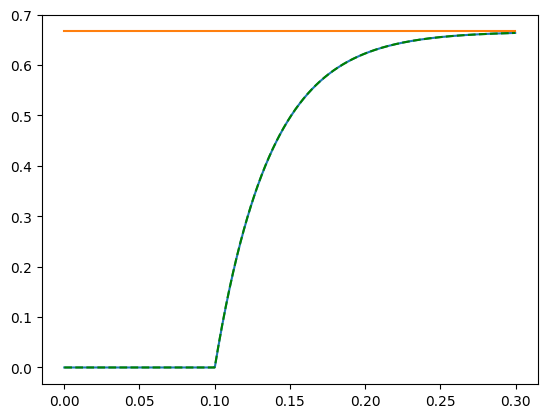

In [18]:
import matplotlib.pyplot as plt

plt.plot(tout, yout)
plt.plot((tout[0], tout[-1]), (solution.get_voltage('C'), solution.get_voltage('C')))
plt.plot(tout, u_ref, 'g--')
